# Our Dummy project

Basic components of DS project

# Dependencies

In [103]:
%matplotlib inline

import pandas as pd
from sklearn.datasets import make_classification
from yellowbrick.features import Rank1D, Rank2D, JointPlotVisualizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import FeatureImportances

## Getting data

Also referred to as 'Analytical Base Table'.

In [104]:
X, y = make_classification(n_samples = 10000, n_features = 20, n_informative=15, n_redundant=2, n_classes=2, weights = [.9, .1], random_state = 42)
X = pd.DataFrame(X)

## Explore features

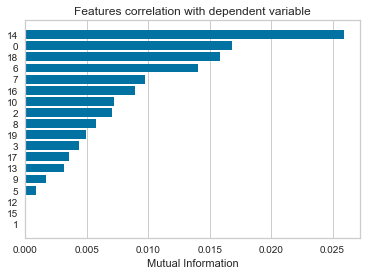

In [126]:
from yellowbrick.target import FeatureCorrelation

visualizer = FeatureCorrelation(
    method='mutual_info-classification', sort=True
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()              # Draw/show/poof the data

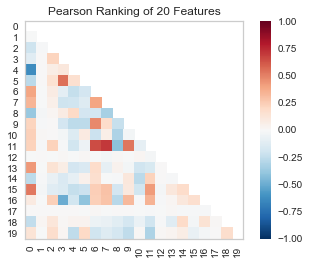

In [106]:
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(X, y)        
visualizer.transform(X)
visualizer.poof()

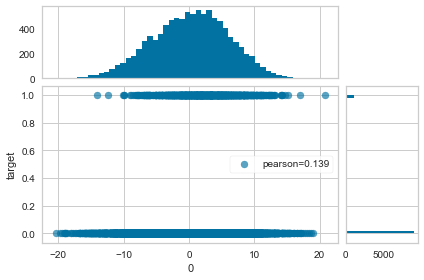

In [107]:
visualizer = JointPlotVisualizer(columns=0)

visualizer.fit_transform(X, y)        # Fit and transform the data
visualizer.poof()                     # Draw/show/poof the data

## First feature selection

Let's drop the highly correlated features

In [108]:
X = X.drop([4, 11], axis = 1)

## Train Test Split

Very basic stratified train/test split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

## Base model 

In [110]:
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto', random_state=42)
rf.fit(X_train, y_train)

def eval_model(clf, X_train, y_train, X_test, y_test):
    cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()

    yhat = [x[1] for x in clf.predict_proba(X_test)]
    test_score = roc_auc_score(y_test, yhat)

    print(f"Classifier: {clf.__class__}\nCV score:   {cv_score:.4f}\nTest score: {test_score:.4f}")
    
eval_model(rf, X_train, y_train, X_test, y_test)

Classifier: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score:   0.8941
Test score: 0.8796


## Hyperparameter tuning

Cross validated hyper parameter tuning on train

In [111]:
parameters = {'max_depth': [3,5,7,10], 'n_estimators':[10,50,100]}

clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [112]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Tuned model

In [113]:
rf = RandomForestClassifier(max_depth=10, n_estimators=10, max_features='auto', random_state=42)
rf.fit(X_train, y_train)

eval_model(rf, X_train, y_train, X_test, y_test)

Classifier: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score:   0.9292
Test score: 0.9305


## Feature importances

Many ways to inspect this! One honorable mention is ING's [lofo-importance](https://github.com/aerdem4/lofo-importance) package 

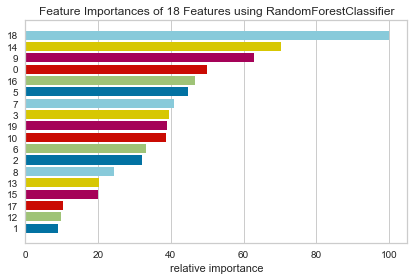

In [114]:
# using RF importance
viz = FeatureImportances(rf)
viz.fit(X, y)
viz.poof()

## Second feature selection

Let's drop our unimportant features and see if our model improves.

In [115]:
X_train = X_train.drop([1,12,17], axis = 1)
X_test = X_test.drop([1,12,17], axis = 1)

In [117]:
rf = RandomForestClassifier(max_depth=10, n_estimators=10, max_features='auto', random_state=42)
rf.fit(X_train, y_train)
    
eval_model(rf, X_train, y_train, X_test, y_test)

Classifier: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score:   0.9269
Test score: 0.9221


## GMM model

In [118]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.mixture import GaussianMixture
from sklearn.utils import check_X_y
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted, check_array, FLOAT_DTYPES
import numpy as np
import inspect

def _check_gmm_keywords(kwargs):
    for key in kwargs.keys():
        if key not in inspect.signature(GaussianMixture).parameters.keys():
            raise ValueError(f"Keyword argument {key} is not in `sklearn.mixture.GaussianMixture`")

class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **gmm_kwargs):
        self.gmm_kwargs = gmm_kwargs

    def fit(self, X: np.array, y: np.array) -> "GMMClassifier":
        """
        Fit the model using X, y as training data.
        :param X: array-like, shape=(n_columns, n_samples, ) training data.
        :param y: array-like, shape=(n_samples, ) training data.
        :return: Returns an instance of self.
        """
        X, y = check_X_y(X, y, estimator=self, dtype=FLOAT_DTYPES)
        if X.ndim == 1:
            X = np.expand_dims(X, 1)

        _check_gmm_keywords(self.gmm_kwargs)
        self.gmms_ = {}
        self.classes_ = unique_labels(y)
        for c in self.classes_:
            subset_x, subset_y = X[y == c], y[y == c]
            self.gmms_[c] = GaussianMixture(**self.gmm_kwargs).fit(subset_x, subset_y)
        return self

    def predict(self, X):
        check_is_fitted(self, ['gmms_', 'classes_'])
        X = check_array(X, estimator=self, dtype=FLOAT_DTYPES)
        return self.classes_[self.predict_proba(X).argmax(axis=1)]

    def predict_proba(self, X):
        X = check_array(X, estimator=self, dtype=FLOAT_DTYPES)
        check_is_fitted(self, ['gmms_', 'classes_'])
        res = np.zeros((X.shape[0], self.classes_.shape[0]))
        for idx, c in enumerate(self.classes_):
            res[:, idx] = self.gmms_[c].score_samples(X)
        return np.exp(res)/np.exp(res).sum(axis=1)[:, np.newaxis]
    

gmm = GMMClassifier(n_components=2)
gmm.fit(X_train, y_train)

eval_model(gmm, X_train, y_train, X_test, y_test)

Classifier: <class '__main__.GMMClassifier'>
CV score:   0.9766
Test score: 0.9677


## Ensemble models

In [121]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(max_depth=10, n_estimators=10, max_features='auto', random_state=42)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
gmm = GMMClassifier(n_components=2)

eclf = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('gmm', gmm)], voting='soft')

for clf, label in zip([lr, rf, gmm, eclf], ['Logistic Regression', 'GMM', 'Random Forest', 'Ensemble']):
    clf.fit(X_train, y_train)
    eval_model(clf, X_train, y_train, X_test, y_test)
    
#     scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
#     print("AUC: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

Classifier: <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score:   0.8828
Test score: 0.8455
Classifier: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score:   0.9269
Test score: 0.9221
Classifier: <class '__main__.GMMClassifier'>
CV score:   0.9766
Test score: 0.9677
Classifier: <class 'sklearn.ensemble.voting.VotingClassifier'>
CV score:   0.9730
Test score: 0.9619


## Inspect final model

Let's go with our GMM model

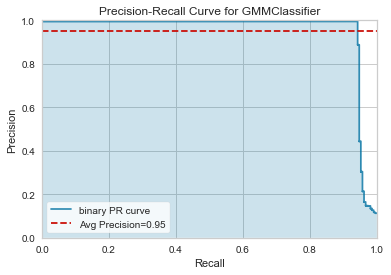

In [123]:
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(gmm)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

## Setting a threshold

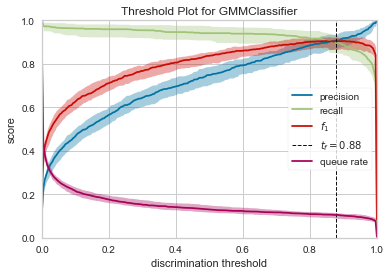

In [124]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(gmm)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data